# Existential Risk Model Solution with Value Function Iteration

This notebook is part of a computational appendix that accompanies the paper

> Existential Risk and The Fermi Paradox
> > Mahon (2021)

Code is adapted from [7 Solution Methods to Solve the Neoclassical Growth Model with Python](https://notes.quantecon.org/submission/5b5f70db9cd7f00015be634e) from the computational appendix of *MATLAB, Python, Julia: What to Choose in Economics?* by Coleman, Lyon, Maliar, and Maliar (2017). 


In [858]:
import math
import numpy as np
import pandas as pd
import scipy.optimize as opt
import statsmodels.api as sm
import time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import namedtuple
from numba import jit, vectorize
import pickle
import os

## Model Description

There is a fixed population of N homogeneous agents who live up to an infinite number of periods.

There are two control variables: consumption ($ c $), and existential risk mitigation $( w )$. Agents maximize their expected lifetime utility with respect to these two variables. 

The are two state variables: a general [common-pool resource](https://en.wikipedia.org/wiki/Common-pool_resource) (CPR), $ X $, and [total-factor productivity](https://en.wikipedia.org/wiki/Total_factor_productivity) (TFP), $ A $. Each agent's production function relies on how much of the CPR they extract $ x_i $, multiplied by $ A $.   
$$
\begin{equation}
    f(x_i, A) = Ax_i \tag{production function}
\end{equation}
$$    
    
Thus, we have the following for the budget constraint: 
$$ 
\begin{align}
    c_i + w_i &\leq Ax_i \tag{B.C.} \\
    \sum_{i=1}^N x_i &\leq X \\
    \implies C + W &\leq AX; \;\; \text{ where } C \equiv \sum_{i=1}^N c_i, \text{ and } W \equiv \sum_{i=1}^N w_i
\end{align}
$$
Whatever CPR remains at the end of a period goes to the next period multiplied by an exogenous rate of replenishment $ g_x $. Using the notation that primes mean a variables value in the next period, we get the following for the law of motion for the CPR. 
$$
\begin{align}
    X' &= ( X - \sum_{i=1}^N x_i )(1 + g_x) \tag{CPR LLM }\\
    &= (X - \frac{C + W}{A})( 1 + g_x )
\end{align}
$$
     
The TFP grows at a constant exponential rate, $ g_a $:
$$
\begin{equation}
    A' = A(1 + g_a)
\end{equation}
$$  

We can combine these last two equations by multiplying the CPR LLM by $  A(1 + g_a) $:
$$
\begin{equation}
    A'X' = (AX - C - W)( 1 + g_x )(1 + g_a) 
\end{equation}
$$ 
    
To simply, denote $ \tilde{X} := A'X' $ and $ g := g_x + g_a + g_x g_a $, such that $ ( 1 + g) = ( 1 + g_x)(1 + g_a) $. Now the problem can be expressed in terms of a single state variable, $ \tilde{X} $. 
$$
\begin{align}
    \tilde{X}' &= (\tilde{X} - C - W)( 1 + g) \\
    C + W &\leq \tilde{X} 
\end{align}
$$ 


The instantaneous utility is a log-utility functon, and we assume the utility of death is zero, i.e. agents are indifferent to being dead and consuming just 1 unit of consumption because $\ln(1) = 0 $, and they prefer death over $ c < 1 $, and prefer life over $ c > 1 $. Future utility is discounted by the subjective discount factor, $ \beta \in [0,1) $. 

There is endogenous probability of civilization ending due to an existential disaster at the end of each period based on the ratio of the current period's total consumption, $ C $, and total existential risk mitigation, $ W $. The scalar constant, $ \bar{a} $, scales the relative effect of $ W $ versus $ C $ on this probability. 
$$
\Pr(\text{ Existiential Disaster } | C, W ) = \frac{C}{C + \bar{a} W}
$$

The agent's problem can be written recursively using the following Bellman equation:

$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta E \bigl[V(\tilde{X}') | C, W\bigr] \biggr\}\\
    & \text{ s.t. } c_i \geq 0; \qquad s_i \geq 0 \\
    & \phantom{\text{ s.t. } } C + W \leq \tilde{X}\\
    & \phantom{\text{ s.t. } } \tilde{X}' = (\tilde{X} - C - W)(1 + g) 
\end{align*} 
$$

Note:
$$
\begin{align}
    E \bigl[V(\tilde{X}') | C, W\bigr] &= \bigg( 1 - \Pr(\text{ Existiential Disaster } | C, W )\bigg)V(\tilde{X}') \\
    &= \frac{\bar{a}W}{C + \bar{a} W}V(\tilde{X}') 
\end{align} 
$$
    
Thus, the problem can be expressed deterministically:
$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta \frac{\bar{a}W}{C + \bar{a} W} V(\tilde{X}')\biggr\}\\
    & \text{ s.t. } c_i \geq 0; \qquad s_i \geq 0 \\
    & \phantom{\text{ s.t. } } C + W \leq \tilde{X}\\
    & \phantom{\text{ s.t. } } \tilde{X}' = (\tilde{X} - C - W)(1 + g) 
\end{align*} 
$$

## Python Code

We begin by defining a `namedtuple` that contains the parameters of our model. This is useful to pass the parameters around to functions that are just-in-time (JIT) compiled by `numba`.

In [396]:
#
# Create a named tuple type that we can pass into the jitted functions
# so that we don't have to pass parameters one by one
#
Params = namedtuple("Params", ["N", "beta", "g", "a_bar"])

@jit(nopython=True)
def param_unpack(params):
    "Unpack parameters from the Params type"
    out = (params.N, params.beta, params.g,
           params.a_bar)

    return out

We will then define various helper functions to ensure that we [don't repeat ourselves](https://lectures.quantecon.org/py/writing_good_code.html#don-t-repeat-yourself) and that the inner functions can be JIT compiled.

In [397]:
#
# Helper functions to make sure things are jitted
#
@vectorize(nopython=True)
def u(c):
    "log utility function"
    return -1e10 if c < 1e-10 else np.log(c)

@vectorize(nopython=True)
def psurvival(a_bar, c, w):
    return a_bar*w/(c + a_bar*w)

# def lin_smoother(x, y):
#     return interp1d([x[0], x[-1]], [y[0], y[-1]])(x)

# def lowess_smoother(x,y):
#     return sm.nonparametric.lowess(y, x, is_sorted=True, return_sorted=False)

    

## Envelope Condition 

Denote the optimal $ \tilde{X}' $ as $ \tilde{X}^{\prime \ast} $ and the optimal $ c $ and $ w $ as $ c^\ast $ and $ w^\ast $. 

$ \tilde{X}^{\prime \ast}$ is defined as the following:
$$ \begin{equation}
\tilde{X}^{\prime \ast} \equiv (\tilde{X} - C(c^\ast) - W(w^\ast))(1 + g)
\end{equation}
$$
With total consumption $ C $ and total risk reduction investment $ W $ expressed as functions of the representative agents choices. 

$ W(w^\ast) $ can now be expressed as:
$$ \begin{equation}
W(w^\ast) \equiv \tilde{X}  - \frac{\tilde{X}^{\prime \ast}}{1 + g} - C(c^\ast)
\end{equation}
$$
Thus, fixing $ w $ and $ \tilde{X}' $ at the optimum, the problem can be described with consumption as the only control variable:
$$
\begin{align*}
    V(\tilde{X}) &= \max_{c} \biggl\{\ln(c) + \beta \frac{\bar{a}\bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c)\bigg)}{C(c) + \bar{a} \bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c) \bigg)} V(\tilde{X}^{\prime\ast} )\biggr\}
\end{align*} 
$$
We can now solve for $ c^\ast $ using the FOC:
$$
\begin{align}
c^\ast &= - \Bigg\{ \beta V(\tilde{X}^{\prime \ast}) \frac{d}{dc}\Bigg(\frac{\bar{a}\bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c)\bigg)}{C(c) + \bar{a} \bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c) \bigg)} \Bigg) \Bigg\}^{-1}
\end{align}
$$

The envelope condition tells us that at the optimum, $ V(\tilde{X}') $ must equal $ V(\tilde{X}^{\prime \ast}) $. Thus, changes in the optimizers $ c $ and $ w $ will not change $ V(\tilde{X}^{\prime \ast}) $ in a sense because it is already defined as being at the optimum.    the value function can be written as:
$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta \frac{\bar{a}W(w_i)}{C(c_i) + \bar{a} W(w_i)} V(\tilde{X}^{\prime\ast} )\biggr\}
\end{align*} 
$$

#### Social Optimum
At the social optimum, we maximize w.r.t. to the same $ c $ for everyone so, $ C(c) = Nc $. Thus, at the social optimum we get the following for $ c^\ast $ from the first order condition.
$$ 
\begin{align*}
    c^\ast &=  \frac{\bar{a} (X(1 + g) - \tilde{X}^{\prime \ast} ) \bigg(2 (\bar{a} - 1) + \beta V(\tilde{X}^{\prime \ast})  - \sqrt{\beta V(\tilde{X}^{\prime \ast})  \bigg(\beta V(\tilde{X}^{\prime \ast}) + 4 (\bar{a} - 1 )\bigg)}\bigg)}{2 N (\bar{a} - 1)^2 (1 + g)}
\end{align*}
$$

In [398]:
@vectorize(nopython=True)
def so_foc_c(X, Xp, Vp, a_bar, beta, N, g):
    """
    Social optimum c expressed in terms of optimal X' from first order condition.
    Ensure values can not be negative nor exceed X/N
    """
    return (
            a_bar*(X*(1 + g) - Xp)*(
                2*(a_bar - 1) + beta*Vp - (
                    beta*Vp*(
                        beta*Vp + 4*(a_bar - 1)
                    )
                )**0.5
            )
        )/(
            2*N*((a_bar - 1)**2)*(1 + g)
        )

@vectorize(nopython=True)
def so_foc_w(X, Xp, N, g, c):
    "Social optimum w expressed in terms of optimal X' and c from first order condition"
    return (X - Xp/(1 + g) - N*c)/N



#### Market Equilibrium
At the market equilibriums agent's maximize their own individual utility with respect to their own consumption values for $ c $ and $ w $. They optimize against the other agents' choices, which we donote as $ \bar{c} $. All other agents must make the same choice since this is a homogeneous agent model, thus $ C(c) $ becomes $ c + (N-1)\bar{c} $, and now we can use the same process to find $ c^\ast $ in terms of the optimal $ \tilde{X}^{\prime \ast } $ and the model conditions, which include the strategies of the other agents. The result to this FOC is much longer than the one for the social optimum, so rather than simplifying it, the solution, which was computed in MATLAB, has been adapted to the Python function shown below:

In [399]:
@vectorize(nopython=True)
def me_foc_c(X, Xp, Vp, a_bar, beta, N, g, c_bar):
    "Market Equilibrium c expressed in terms of optimal X' from first order condition"
    return (
        2*c_bar - (
          Vp*a_bar*beta*(X - Xp + X*g)*(
            4*c_bar 
            - 4*N*c_bar 
            - 4*X*a_bar 
            + 4*Xp*a_bar 
            - 8*a_bar*c_bar 
            + 4*c_bar*g 
            + 4*X*a_bar**2 
            - 4*Xp*a_bar**2 
            + 4*a_bar**2*c_bar 
            + 8*N*a_bar*c_bar 
            - 4*N*c_bar*g 
            - 4*X*a_bar*g 
            - 8*a_bar*c_bar*g 
            - 4*N*a_bar**2*c_bar 
            + 4*X*a_bar**2*g 
            + 4*a_bar**2*c_bar*g 
            - 4*N*a_bar**2*c_bar*g 
            + Vp*X*a_bar*beta 
            - Vp*Xp*a_bar*beta 
            + 8*N*a_bar*c_bar*g 
            + Vp*X*a_bar*beta*g
            )
        )**(1/2) 
        - 2*N*c_bar 
        - 2*X*a_bar 
        + 2*Xp*a_bar 
        - 4*a_bar*c_bar 
        + 2*c_bar*g 
        + 2*X*a_bar**2 
        - 2*Xp*a_bar**2 
        + 2*a_bar**2*c_bar 
        + 4*N*a_bar*c_bar 
        - 2*N*c_bar*g 
        - 2*X*a_bar*g 
        - 4*a_bar*c_bar*g 
        - 2*N*a_bar**2*c_bar 
        + 2*X*a_bar**2*g 
        + 2*a_bar**2*c_bar*g 
        - 2*N*a_bar**2*c_bar*g 
        + Vp*X*a_bar*beta 
        - Vp*Xp*a_bar*beta 
        + 4*N*a_bar*c_bar*g 
        + Vp*X*a_bar*beta*g
      )/(
        2*(
          g - 2*a_bar - 2*a_bar*g + a_bar**2*g + a_bar**2 + 1
        )
      )

@vectorize(nopython=True)
def me_foc_w(X, Xp, N, g, c_bar, w_bar, c):
    "Market Eq'm w expressed in terms of optimal X' and c from first order condition"
    return X - Xp/(1 + g) - (N-1)*(c_bar + w_bar) - c


### The Policy and Value Function 

Now that we can derive $ c^\ast $ and $ w^\ast $ from $ \tilde{X}^{\prime \ast } $ and $ V(\tilde{X}^{\prime \ast }) $, we just need to find functions for these two values in terms of the current state $ \tilde{X} $. A policy function: $ \widehat{\tilde{X}^{\prime \ast } }(\tilde{X})$, and a value function: $ \widehat{V}(\tilde{X}) $. 

However, traditional approaches to this particular model will not work because until the model is solved, we can not know how many periods this economy will survive until. Given some initial conditions the equilibrium may be for the CPR to potentially stay positive forever. Other conditions could lead to the CPR being entirely depleted in one period, or depleted in $ n $ periods from the present. Thus, this model has an endogenous time horizon, $ \in [0, \infty) $. This means that no analytical function could fully express these solutions on their, and because the state could also grow infinitely, traditional non-analytic approaches, such as spline functions will do a poor job of extrapolating values outside of the fitted range. 

This leads us to the following two-part approach. We will use a linear spline for low state values, $ \tilde{X} $, where there is a lot of discontinuity, and an analytic function for high $ \tilde{X} $, which could competently extrapolate estimates for $ \tilde{X} $ higher than what it was fitted on.

Through trial and error, we find that on the analytic portion of the domain for these functions, $ \widehat{\tilde{X}^{\prime \ast } }(\tilde{X}; b) $ follows a simple linear equation:
$$
\begin{align}
 \widehat{\tilde{X}^{\prime \ast } }(\tilde{X}; b) = b_0 + b_1\tilde{X}
\end{align}
$$

And $ \widehat{V}(\tilde{X}; b) $ can be estimated with the following nonlinear functional form:
$$
\widehat{V}(\tilde{X}; b) = b_0 + b_1 \frac{\ln(\tilde{X})}{b_2 - \tilde{X}^{b_3}}
$$

Their Python functions are shown below. 

In [400]:
def x_curve(x, b0, b1):
    "X' policy function curve"
    return b0 + b1*x


def v_curve(x,  b0, b1, b2, b3):
    "Value function curve"
    return b0 + b1*np.log(x)/(b2 - (x**b3))



We also now define a class that contains

1. Parameters of the model
2. A grid used for approximating the solution

This again helps us maintain all of the relevant information in one place and simplifies passing it to other functions.

In [401]:
class ExistentialRiskModel(object):
    """
    * N: Population Size
    * beta: subjective discount factor
    * g_x: CPR regrowth rate
    * g_a: TFP growth rate
    * a_bar: Exisitentail risk reduction scaling parameter
    """
    def __init__(self, N=1, beta=0.95, g_x=0.05, g_a=0.015, a_bar=1e5, 
                 xmin=1, xmax=3000, nx=100, xsplit_idx=50):
        # calculate g from g_a and g_x 
        g = g_a + g_x + g_a*g_x

        # Household parameters
        self.beta = beta

        # Economy parameters
        self.N, self.g, self.a_bar = N, g, a_bar
            
        self.xgrid = N*np.geomspace(xmin, xmax, nx)
        # store the state value that splits the two parts of the solution and its index in the xgrid
        self.xsplit_idx = xsplit_idx
        self.xsplit = self.xgrid[xsplit_idx]
        
    def _unpack_params(self):
        out = (self.N, self.beta, self.g, self.a_bar)
        return out

    def _unpack_grids(self):
        out = (self.xgrid)
        return out


In [402]:
class GeneralSolution:
    """
    This is a general solution method. We define this, so that we can
    sub-class it and define specific update methods for each particular
    solution method
    """
    def __init__(self, erm, prev_sol=None, maxfev=10000, 
                 interpolator='linear', xsplit=None):
        # Save model and approximation degree
        self.erm,  self.maxfev, self.interpolator = erm, maxfev, interpolator

        # Unpack some info from erm
        N, beta, g, a_bar = self._unpack_params()
        X = self.erm.xgrid
        if xsplit is None:
            self.xsplit = self.erm.xsplit
            self.xsplit_idx = self.erm.xsplit_idx
        else:
            self.xsplit = xsplit
            self.xsplit_idx = np.searchsorted(X, xsplit, side='right')
            

        # Use parameter values from model to create a namedtuple with
        # parameters saved inside
        self.params = Params(N, beta, g, a_bar)

        # Update to fill initial value and policy matrices
        # If we give it another solution type then use it to
        # generate values and policies
        if issubclass(type(prev_sol), GeneralSolution):
            self.XP = prev_sol.XP
            self.VF = prev_sol.VF
        else:
            # guess VF and XP
            self.VF = np.log(X/N) 
            self.XP = np.zeros(len(X))

            
        # Fit spline based on guesses
        self.x_spline = interp1d(X
                                 , self.XP
                                 , kind=self.interpolator
                                 , fill_value='extrapolate')
        self.v_spline = interp1d(X[:self.xsplit_idx+1]
                                 , self.VF[:self.xsplit_idx+1]
                                 , kind=self.interpolator
                                 , fill_value='extrapolate')
        
        # Fit coefficients of analytics functions based on guesses
        self.x_coeffs, _ = opt.curve_fit(x_curve
                                         , X[self.xsplit_idx:]
                                         , self.XP[self.xsplit_idx:]
                                         , maxfev=self.maxfev)
        self.v_coeffs, _ = opt.curve_fit(v_curve
                                         , X[int(.88*self.xsplit_idx):]
                                         , self.VF[int(.88*self.xsplit_idx):]
                                         , maxfev=self.maxfev)
    
    def build_VF(self, X=None):
        """
        Using the current coefficients, this builds the value function
        for all states
        """
        if X is None:
            X = self.erm.xgrid
        
        VF = np.maximum(0, np.where(X > self.xsplit
                        , v_curve(X, *self.v_coeffs)
                        , self.v_spline(X)
                    ))
                   

        return VF
    
    def build_XP(self, X=None):
        if X is None:
            X = self.erm.xgrid
        
        XP = np.where(X > self.erm.xgrid[-1]
                        , np.clip(
                                x_curve(X, *self.x_coeffs)
                                , 0, X*(1 + self.erm.g)
                            )
                        , np.clip(
                            self.x_spline(X)
                            , 0, X*(1 + self.erm.g)
                        )
                     )
        return XP
    
    
    def compute_coeffs(self, XP, VF):
        if isinstance(self, IterateOnPolicy):
            new_x_coeffs = self.x_coeffs
        else:
            new_x_coeffs, _ = opt.curve_fit(x_curve
                                            , self.erm.xgrid[self.xsplit_idx:]
                                            , XP[self.xsplit_idx:]
                                            , maxfev=self.maxfev)
        
        new_v_coeffs, _ = opt.curve_fit(v_curve
                                        , self.erm.xgrid[int(.88*self.xsplit_idx):]
                                        , VF[int(.88*self.xsplit_idx):]
                                        , maxfev=self.maxfev) 
        
        return new_x_coeffs, new_v_coeffs
    
    def compute_splines(self, XP, VF):
        if isinstance(self, IterateOnPolicy):
            new_x_spline = self.x_spline
        else:
            new_x_spline = interp1d(self.erm.xgrid
                                    , XP
                                    , kind=self.interpolator
                                    , fill_value='extrapolate')
        
        new_v_spline = interp1d(self.erm.xgrid[:self.xsplit_idx+1]
                                , VF[:self.xsplit_idx+1]
                                , kind=self.interpolator
                                , fill_value='extrapolate')
        
        return new_x_spline, new_v_spline

    def _unpack_params(self):
        return self.erm._unpack_params()

    def update_v(self, new_v_coeffs, new_v_spline):
        """
        Updates the coefficients for the value function
        """
        self.v_coeffs = new_v_coeffs
        self.v_spline = new_v_spline

        return None

    def update_x(self, new_x_coeffs, new_x_spline):
        """
        Updates the coefficients for the policy function
        """
        self.x_coeffs = new_x_coeffs
        self.x_spline = new_x_spline
        
        return None
    

    def compute_distance(self, XP, VF):
        """
        Computes average distance between policy functions
        """
        return np.max(np.abs(1.0 - (XP+1e-12)/(self.XP+1e-12)))
    

    def solve(self, tol=1e-6, maxiter=2500, verbose=False, nskipprint=25, dampen=0.8):
        # Iterate until convergence
        dist, it = 10.0, 0
        while (dist>tol) and (it<maxiter):
            # Run solution specific update code
            XP, VF = self.update()

            # Update distance and iterations
            dist = self.compute_distance(XP, VF)
            it += 1
            if verbose and it%nskipprint == 0:
                print(it, dist)
                print('max dist idx: ', np.argmax(np.abs(1.0 - (XP+1e-12)/(self.XP+1e-12))))
            
            # update policy and value functions w/dampening
            self.XP = dampen*XP + (1-dampen)*self.XP
            self.VF = dampen*VF + (1-dampen)*self.VF
            
            # Compute new policy and value coeffs
            new_x_coeffs,  new_v_coeffs = self.compute_coeffs(self.XP, self.VF)
            new_x_spline, new_v_spline = self.compute_splines(self.XP, self.VF)
            
            # Update functions params
            self.update_x(new_x_coeffs, new_x_spline)
            self.update_v(new_v_coeffs, new_v_spline)

        # After finishing iteration, iterate to convergence using policy
        if not isinstance(self, IterateOnPolicy):
            sol_iop = IterateOnPolicy(self.erm, prev_sol=self, maxfev=self.maxfev)
            XP, VF = sol_iop.solve(tol=tol)
            
            # update policy and value functions w/dampening
            self.XP = dampen*XP + (1-dampen)*self.XP
            self.VF = dampen*VF + (1-dampen)*self.VF

            
            new_x_coeffs, new_v_coeffs = sol_iop.compute_coeffs(self.XP, self.VF)
            new_x_spline, new_v_spline = sol_iop.compute_splines(self.XP, self.VF)
            self.update_x(new_x_coeffs, new_x_spline)
            self.update_v(new_v_coeffs, new_v_spline)

        return self.XP, self.VF
    
    """
    This is where we run the Bellman operator on the policy and value functions.
    Updating their new values before fitting new functions on each iteration.
    """
    def update(self):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        xgrid = self.erm.xgrid
        n_state = xgrid.shape[0]

        # Get the policy and update it
        XP = np.empty(n_state)
        XP[0] = 0
        VF = np.empty(n_state)
        VF[0] = np.log(xgrid[0]/N)
        for i_s in range(1,n_state):
            # Pull out current state
            x = xgrid[i_s]        

            _xp, fval, _, _ = opt.fminbound(lambda _xp: -self.compute_V(X=x, XP=_xp)
                        , 0
                        , x*(1+g)
                        , xtol=1e-12
                        , full_output=True
                    )
            _vf = -fval

            vf_corner = self.compute_V(X=x, XP=0)
            if (_vf <= vf_corner):
                _xp = 0
                _vf = vf_corner

            XP[i_s] = _xp
            VF[i_s] = _vf 

  
        return XP, VF
        


In [403]:
class Social_Optimum(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def build_CP(self, X=None, XP=None, Vp=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
        
        if XP is None:
            XP = self.build_XP(X)
            
        if Vp is None:
            Vp = self.build_VF(XP)
        
        exp = np.maximum(0, X - XP/(1+g))
            
        return np.clip(so_foc_c(X, XP, Vp, a_bar, beta, N, g), 0, exp/N)
    
    def build_WP(self, X=None, XP=None, CP=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
            
        
        if XP is None:
            XP = self.build_XP(X)
            
        if CP is None:
            CP = self.build_CP(X=X, XP=XP)
        
        return so_foc_w(X, XP, N, g, CP)
    
    def compute_V(self, X=None, XP=None, Vp=None, CP=None, WP=None):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        
        if Vp is not None and CP is not None and WP is not None:
            VF = u(CP) + beta*psurvival(a_bar, CP, WP)*Vp
            
        else:
            if X is None:
                X = self.erm.xgrid
                
                
            if XP is None:
                XP = self.build_XP(X)
                
            if Vp is None:
                Vp = self.build_VF(XP)
                
            if CP is None:
                CP = self.build_CP(X=X, XP=XP, Vp=Vp) 
                
            if WP is None:
                WP = self.build_WP(X=X,XP=XP,CP=CP) 
                
            VF = u(CP) + beta*psurvival(a_bar, CP, WP)*Vp
            
        return np.maximum(0, VF)

    
    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the existential risk model with policy function
        given by self.XP. Run Simulation for T periods, and use s 
        to scale policy function estimates to check how well model 
        performs compared to slight modifications. The simulation results
        should ideally be highest when s=1. 
        """
        N, beta, g, a_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
            
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= min(T, 2000):
                return u(x/N), 1, x, t
            c_corner = x/N 
            u_corner = u(c_corner)
            if u_corner <= 0:
                return 0, 0, x, t
            
            xp = self.build_XP(x)
            if xp <= 0:
                return u_corner, 0, 0, t+1
            if s != 1:
                xp = s*xp
            xp = min(xp, x*(1+g)-1e-10) # xp = x*(1+g), would result in c = 0, log(0)= -infinity in current period
            
            vp_hat = self.build_VF(xp)
            c = np.clip(self.build_CP(X=x,XP=xp,Vp=vp_hat)
                        ,1e-10,c_corner)
            w = self.build_WP(X=x, XP=xp, CP=c)
            
            p_t = psurvival(a_bar, c, w)
            u_t = u(c)
            
            vp, pp, final_state, nperiods = recurse_bellman(xp, t+1)            
            
            if u_t + beta*p_t*vp <= u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + beta*p_t*vp, p_t*pp, final_state, nperiods
        
        T_counter = 0 
        psurvived = 1
        total_VP = 0
        while T > 0:
            vp, pp, X, nperiods = recurse_bellman(X, 0)
            total_VP += beta**(T_counter)*psurvived*vp
            psurvived *= pp
            T_counter += nperiods
            T -= 2000
            
        return total_VP, psurvived, X, T_counter

### Iterating to Convergence (given policy)

This isn't one of the methods described above, but it is used as an element of a few of our methods (and also as a way to get a first guess at the value function). This method takes an initial policy function, $\hat{\tilde{X}^{\prime\ast}}(\tilde{X})$, as given, and then, without changing the policy, iterates until the value function has converged.

Thus the "update section" of the algorithm in this instance would be:

* Leave policy function unchanged
* At each point of grid, $(\tilde{X})$, compute $\hat{V}(\tilde{X}) = u\bigg(c^\ast\big(\hat{\tilde{X}^{\prime\ast}}(\tilde{X})
\big)\bigg) + \beta E \left[ V(\hat{\tilde{X}^{\prime\ast}}(\tilde{X})) \right]$

We override the methods from `GeneralSolution`

* `compute_distance` because when we are iterating to convergence on the value function we want to check distnace using value function rather than policy function


The `update` method just repeatedly applies a particular policy function to update the value function.

In [404]:
class IterateOnPolicy(Social_Optimum):
    """
    Subclass of the general solution method. The update method for this
    class simply computes the fixed point of the value function given
    a specific policy
    """
    def compute_distance(self, XP, VF):
        """
        Computes distance between policy functions. When we are
        iterating on a specific policy, we would like to compute
        distances by the difference between VFs
        """
        return np.max(np.abs(1.0 - (VF +1e-12)/(self.VF +1e-12)))
    
    def update(self):
        VF = self.compute_V(XP=self.XP)
        
        return self.XP, VF
    

In [412]:
class MarketEquilibrium(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def __init__(self, *args, prev_sol_bar=None, dampen=0.8, **kwargs):
        super().__init__(*args, **kwargs)
        N, beta, g, a_bar = self._unpack_params()
        
        if prev_sol_bar is None:
            self.prev_sol_bar = kwargs['prev_sol'].prev_sol_bar
        else:
            self.prev_sol_bar = prev_sol_bar
        
        XPbar = self.prev_sol_bar.build_XP()

        CPbar = self.build_CPbar(XPbar=XPbar)
        WPbar = self.prev_sol_bar.build_WP(XP=XPbar, CP=CPbar)
        # dampen policy functions to ensure convergence 
        if hasattr(self.prev_sol_bar, 'CPbar'):
            CPbar = dampen*CPbar + (1 - dampen)*self.prev_sol_bar.CPbar
            WPbar = dampen*WPbar + (1 - dampen)*self.prev_sol_bar.WPbar
        
        self.CPbar = CPbar
        self.WPbar = WPbar
        
    # find convergence without any reliance on build_XP()
    def build_CP(self, X=None, XP=None, Vp=None, 
                 CPbar=None, WPbar=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
            
            if CPbar is None:
                CPbar = self.CPbar
            if WPbar is None:
                WPbar = self.WPbar
        
        if XP is None:
            XP = self.build_XP(X)
            
        if Vp is None:
            Vp = self.build_VF(XP)
            
        if CPbar is None:
            CPbar = self.build_CPbar(X=X)
            
        if WPbar is None:
            WPbar = self.prev_sol_bar.build_WP(X=X, CP=CPbar)
        
        # expendables
        exp = np.maximum(0, X - XP/(1+g) - (N-1)*(CPbar + WPbar))
                
            
        CP = np.clip(
                np.nan_to_num(me_foc_c(X, XP, Vp, a_bar, beta, N, g, CPbar), nan=1e-10)
                , 0, exp
            )
            
        return CP
    
    def build_WP(self, X=None, XP=None, CP=None, CPbar=None, WPbar=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
            
            if CPbar is None:
                CPbar = self.CPbar
            if WPbar is None:
                WPbar = self.WPbar
                
        if XP is None:
            XP = self.build_XP(X)
        
        if CPbar is None:
            CPbar = self.build_CPbar(X=X)
        
        if WPbar is None:
            WPbar = self.prev_sol_bar.build_WP(X=X, CP=CPbar)
            
        if CP is None:
            CP = self.build_CP(X=X, XP=XP, CPbar=CPbar, WPbar=WPbar)
        
        WP = me_foc_w(X, XP, N, g, CPbar, WPbar, CP)
        
        return WP
    
    def build_CPbar(self, X=None, XPbar=None, Vpbar=None):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        
        return np.minimum(
            self.erm.xgrid/N
            , self.prev_sol_bar.build_CP(X=X, XP=XPbar, Vp=Vpbar)
        )
    
    def compute_V(self, X=None, XP=None, Vp=None, CP=None, WP=None, 
                  CPbar=None, WPbar=None):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        
        if Vp is not None and CP is not None and WP is not None and CPbar is not None and WPbar is not None:
            VF = u(CP) + beta*psurvival(a_bar, CP + (N-1)*CPbar, WP + (N-1)*WPbar)*Vp
            
        else:
            if X is None:
                X = self.erm.xgrid
                
                if CPbar is None:
                    CPbar = self.CPbar
                if WPbar is None:
                    WPbar = self.WPbar
                
            if XP is None:
                XP = self.build_XP(X)
                
            if Vp is None:
                Vp = self.build_VF(XP)
                
            if CPbar is None:
                CPbar = self.build_CPbar(X=X)

            if WPbar is None:
                WPbar = self.prev_sol_bar.build_WP(X=X, CP=CPbar)
                
            if CP is None:
                CP = self.build_CP(X=X, XP=XP, Vp=Vp, CPbar=CPbar, WPbar=WPbar) 
                
            if WP is None:
                WP = self.build_WP(X=X,XP=XP,CP=CP, CPbar=CPbar, WPbar=WPbar) 
                
            VF = u(CP) + beta*psurvival(a_bar, CP + (N-1)*CPbar, WP + (N-1)*WPbar)*Vp
            
        return np.maximum(0, VF)
    
    def update(self):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        xgrid = self.erm.xgrid
        n_state = xgrid.shape[0]

        # Get the policy and update it
        XP = np.empty(n_state)
        XP[0] = 0
        VF = np.empty(n_state)
        VF[0] = np.log(xgrid[0]/N)
        for i_s in range(1,n_state):
            x = xgrid[i_s]   
            cp_bar = self.CPbar[i_s]
            wp_bar = self.WPbar[i_s]


            _xp, fval, _, _ = opt.fminbound(lambda _xp: -self.compute_V(X=x, XP=_xp, CPbar=cp_bar, WPbar=wp_bar)
                        , 0
                        , x*(1+g)
                        , xtol=1e-12
                        , full_output=True
                    )
            _vf = -fval

            vf_corner = self.compute_V(X=x, XP=0, CPbar=cp_bar, WPbar=wp_bar)
            if (_vf <= vf_corner):
                _xp = 0
                _vf = vf_corner

            XP[i_s] = _xp
            VF[i_s] = _vf 
        
        return XP, VF
    
    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the existential risk model with policy function
        given by self.XP. Run Simulation for T periods, and use s 
        to scale policy function estimates to check how well model 
        performs compared to slight modifications. The simulation results
        should ideally be highest when s=1. 
        """
        N, beta, g, a_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
            
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= min(T, 2000):
                return u(x/N), 1, x, t
            
            c_bar = self.build_CPbar(X=x)
            if c_bar >= x/N:
                c_bar = x/N
                w_bar = 0
            else:
                w_bar = self.prev_sol_bar.build_WP(X=x, CP=c_bar)
            
            c_corner = x - (N-1)*(c_bar + w_bar)
            u_corner = u(c_corner)
            if u_corner <= 0:
                return 0, 0, x, t
            
            xp = self.build_XP(x)
            if xp <= 0:
                return u_corner, 0, 0, t+1
            if s != 1:
                xp = s*xp
            xp = min(xp, x*(1+g)-1e-10) # xp = x*(1+g), would result in c = 0, log(0)= -infinity in current period
            
            vp_hat = self.build_VF(xp)
            c = np.clip(self.build_CP(X=x,XP=xp,Vp=vp_hat, CPbar=c_bar, WPbar=w_bar)
                        ,1e-10,c_corner)
            w = self.build_WP(X=x, XP=xp, CP=c, CPbar=c_bar, WPbar=w_bar)
            
            p_t = psurvival(a_bar, c + (N-1)*c_bar, w + (N-1)*w_bar)
            u_t = u(c)
            
            vp, pp, final_state, nperiods = recurse_bellman(xp, t+1)            
            
            if u_t + beta*p_t*vp <= u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + beta*p_t*vp, p_t*pp, final_state, nperiods
        
        T_counter = 0 
        psurvived = 1
        total_VP = 0
        while T > 0:
            vp, pp, X, nperiods = recurse_bellman(X, 0)
            total_VP += beta**T_counter*psurvived*vp
            psurvived *= pp
            T_counter += nperiods
            T -= 2000
            
        return total_VP, psurvived, X, T_counter
    
class IterateOnPolicy(MarketEquilibrium):
    """
    Subclass of the general solution method. The update method for this
    class simply computes the fixed point of the value function given
    a specific policy
    """
    def compute_distance(self, XP, VF):
        """
        Computes distance between policy functions. When we are
        iterating on a specific policy, we would like to compute
        distances by the difference between VFs
        """
        return np.max(np.abs(1.0 - (VF+1e-12 )/(self.VF +1e-12)))
    
    def update(self):
        VF = self.compute_V(XP=self.XP)
        
        return self.XP, VF
    
    

### Run market Equilibrium Solutions and load

In [649]:
N = 2

In [650]:
# load solutions
path = f"./pickle/{N}"
with open(path + '/solutions.pickle', 'rb') as f:
    solutions = pickle.load(f)

In [651]:
from scipy import stats

sol_XPs = np.array([sol.XP for sol in solutions])
sol_VFs = np.array([sol.VF for sol in solutions])

XP = stats.trim_mean(sol_XPs[1:], 0.25, axis=0)
VF = stats.trim_mean(sol_VFs[1:], 0.25, axis=0)

In [652]:
old_sol = solutions[-1]

old_sol.XP = XP
old_sol.VF = VF

# Compute new policy and value coeffs
new_x_coeffs,  new_v_coeffs = old_sol.compute_coeffs(XP, VF)
new_x_spline, new_v_spline = old_sol.compute_splines(XP, VF)

# Update functions params
old_sol.update_x(new_x_coeffs, new_x_spline)
old_sol.update_v(new_v_coeffs, new_v_spline)

/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [653]:
erm = solutions[-1].erm
new_sol2 = MarketEquilibrium(erm, maxfev=100000, prev_sol=old_sol, interpolator='linear'
                        , prev_sol_bar=old_sol, dampen=0.8)


ts = time.time()
new_sol2.solve(tol=1e-6, verbose=True, nskipprint=25, maxiter=500)
time_took = time.time() - ts
print(time_took)

<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-412-67f916e9fe6e>:134: RuntimeWarning: divide by zero encountered in u
  VF = u(CP) + beta*psurvival(a_bar, CP + (N-1)*CPbar, WP + (N-1)*WPbar)*Vp
<ipython-input-412-67f916e9fe6e>:57: RuntimeWarning: invalid value encountered in me_foc_c
  np.nan_to_num(me_foc_c(X, XP, Vp, a_bar, beta, N, g, CPbar), nan=1e-10)
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in double_scalars
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ip

1.205298900604248


In [934]:
N, beta, g, a_bar = erm._unpack_params()
X = erm.xgrid
x = X/N
rng = range(0,300)


In [935]:
class MarketEquilibriumSIM(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def __init__(self, *args, CP=None, WP=None,**kwargs):
        super().__init__(*args, **kwargs)
        N, beta, g, a_bar = self._unpack_params()
        
        X = erm.xgrid
        
        sol = kwargs['prev_sol']
        XP = sol.XP
        
        if CP is None:
            CP = sol.build_CP(XP=XP)
            
        if WP is None:
            WP = sol.build_WP(XP=XP, CP=CP)
        
        # Fit c spline based on guesses
        self.c_spline = interp1d(X
                                 , CP
                                 , kind='linear'
                                 , fill_value='extrapolate')
        
        self.w_spline = interp1d(X
                         , WP
                         , kind='linear'
                         , fill_value='extrapolate')
        
    def build_XP(self, X=None, CP=None, WP=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
        
        if CP is None:
            CP = self.build_CP(X=X)
            
        if WP is None:
            WP = self.build_WP(X=X)
            
        return (X - N*(CP + WP))*(1+g)
        
    # find convergence without any reliance on build_XP()
    def build_CP(self, X=None, exp=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
            
        if exp is None:
            exp = X
            
        return np.clip(self.c_spline(X), 0, exp/N)
    
    def build_WP(self, X=None, exp=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
            
        if exp is None:
            exp = X
            
        return np.clip(self.w_spline(X), 0, exp/N)
                
#         if XP is None:
#             XP = self.build_XP(X)
            
#         if CP is None:
#             CP = self.build_CP(X=X)
        
#         WP = np.clip(me_foc_w(X, XP, N, g, CP, 0, CP)/N, 0, X/N)
        
#         return WP

    
    def compute_V(self, X=None, XP=None, Vp=None, CP=None, WP=None):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        
        if Vp is not None and CP is not None and WP is not None:
            VF = u(CP) + beta*psurvival(a_bar, CP , WP )*Vp
            
        else:
            if X is None:
                X = self.erm.xgrid
                
            if XP is None:
                XP = self.build_XP(X)
                
            if Vp is None:
                Vp = self.build_VF(XP)
                
            if CP is None:
                CP = self.build_CP(X=X) 
                
            if WP is None:
                WP = self.build_WP(X=X,exp=(X- XP/(1+g) - N*CP)) 
                
            VF = u(CP) + beta*psurvival(a_bar, CP , WP )*Vp
            
        return np.maximum(0, VF)
    
    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the existential risk model with policy function
        given by self.XP. Run Simulation for T periods, and use s 
        to scale policy function estimates to check how well model 
        performs compared to slight modifications. The simulation results
        should ideally be highest when s=1. 
        """
        N, beta, g, a_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
            
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= min(T, 2000):
                return u(x/N), 1, x, t
            c_corner = x/N 
            u_corner = u(c_corner)
            if u_corner <= 0:
                return 0, 0, x, t
            
            cp = self.build_CP(x)
            if s != 1:
                cp = s*xp
            cp = np.clip(cp, 1e-10, c_corner)
#             wp = self.build_WP(X=x, XP=xp, CP=cp)
            wp = self.build_WP(X=x)
            
            xp = self.build_XP(X=x, CP=cp, WP=wp)
            if xp <= 0:
                return u_corner, 0, 0, t+1
            if xp >= x*(1+g):
                print("ERROR: xp should not exceed value (x*(1+g)=", x*(1+g),"). xp = ", xp, "." )
                return -1,-1,-1,-1
            
            p_t = psurvival(a_bar, cp, wp)
            u_t = u(cp)
            
            vp, pp, final_state, nperiods = recurse_bellman(xp, t+1)            
            
            if u_t + beta*p_t*vp <= u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + beta*p_t*vp, p_t*pp, final_state, nperiods
        
        T_counter = 0 
        psurvived = 1
        total_VP = 0
        while T > 0:
            vp, pp, X, nperiods = recurse_bellman(X, 0)
            total_VP += beta**(T_counter)*psurvived*vp
            psurvived *= pp
            T_counter += nperiods
            T -= 2000
            
        return total_VP, psurvived, X, T_counter
    

    

In [936]:
sol = MarketEquilibriumSIM(erm, maxfev=100000, prev_sol=new_sol2, interpolator='linear')

/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))


<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))


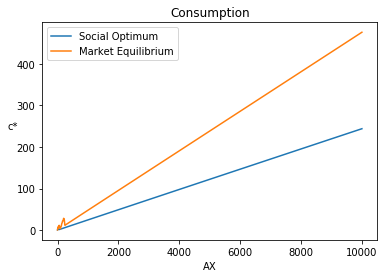

In [706]:
xgrid = np.geomspace(1,10000, 100)
rng = range(0,100)
CP1 = sol.build_CP(X=xgrid)
CPso = solutions[0].build_CP(X=xgrid)

plt.figure(facecolor='white')
plt.plot((xgrid)[rng], CPso[rng], label='Social Optimum')
plt.plot((xgrid)[rng], CP1[rng],  label = ("Market Equilibrium") )


plt.xlabel('AX')
h = plt.ylabel('c*')
h.set_rotation(0)
plt.legend()
plt.title('Consumption')
plt.show()

<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))


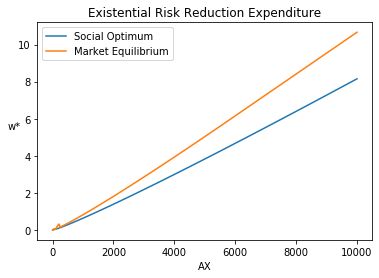

In [707]:
xgrid = np.geomspace(1,10000, 100)
WP1 = sol.build_WP(X=xgrid)
WPso = solutions[0].build_WP(X=xgrid)

plt.figure(facecolor='white')
plt.plot((xgrid)[rng], WPso[rng], label='Social Optimum')
plt.plot((xgrid)[rng], WP1[rng],  label = ("Market Equilibrium") )

plt.xlabel('AX')
h = plt.ylabel('w*')
h.set_rotation(0)
plt.legend()
plt.title('Existential Risk Reduction Expenditure')
plt.show()

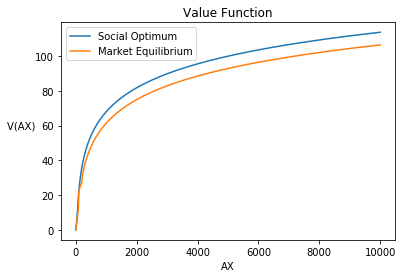

In [943]:
xgrid = np.geomspace(1,10000, 100)
VF1 = sol.build_VF(X=xgrid)
VFso = solutions[0].build_VF(X=xgrid)

plt.figure(facecolor='white')
plt.plot((xgrid)[rng], VFso[rng], label='Social Optimum')
plt.plot((xgrid)[rng], VF1[rng],  label = ("Market Equilibrium") )

plt.xlabel('AX')
h = plt.ylabel('V(AX)      ')
h.set_rotation(0)
plt.legend()
plt.title('Value Function')
plt.show()

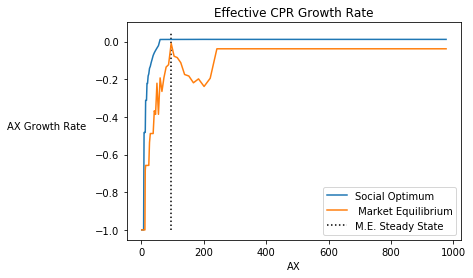

In [709]:
rng = range(0,75)

XP1 = sol.build_XP(X=xgrid)
Xgr1 = (XP1 - xgrid)/xgrid


XPso = solutions[0].build_XP(X=xgrid)
Xgr_so = (XPso - xgrid)/xgrid

plt.figure(facecolor='white')
plt.plot(xgrid[rng], Xgr_so[rng], label='Social Optimum')
plt.plot(xgrid[rng], Xgr1[rng],  label = (' Market Equilibrium') )

plt.vlines(94.94009478093837, -1, .05, linestyles='dotted', label='M.E. Steady State')


plt.xlabel('AX')
h = plt.ylabel('AX Growth Rate               ', labelpad=25)
h.set_rotation(0)
plt.legend()
plt.title('Effective CPR Growth Rate')
plt.show()

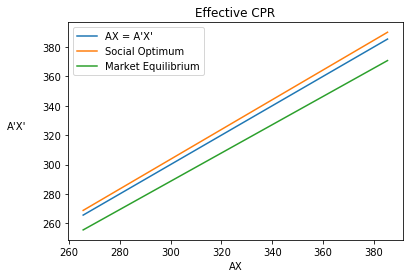

In [891]:
xgrid = np.geomspace(1,10000, 100)
rng = range(60,65)
XP1 = sol.build_XP(X=xgrid)
XPso = solutions[0].build_XP(X=xgrid)

plt.figure(facecolor='white')
plt.plot((xgrid)[rng], (xgrid)[rng], label="AX = A'X'")
plt.plot((xgrid)[rng], XPso[rng], label='Social Optimum')
plt.plot((xgrid)[rng], XP1[rng],  label = ("Market Equilibrium") )

plt.xlabel('AX')
h = plt.ylabel("A'X'", labelpad=25)
h.set_rotation(0)
plt.legend()
plt.title('Effective CPR')
plt.show()

In [696]:
def get_df_sim(sol_i):
    df_sim = pd.DataFrame({
        'X': 275*N,
        'T': [1,5, 10, 25, 50, 100, 250, 500, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 5000, 10000]
    })

    df_sim_res = df_sim.apply(
        lambda x: list(sol_i.simulate(x['X'],x['T'],s=1))
        , axis=1
        , result_type='expand'
    )
    df_sim_res.columns=['val', 'psurvival', 'final_state', 'n_periods']
    df_sim = df_sim.merge(df_sim_res, left_index=True, right_index=True).drop('n_periods', axis=1)
    return df_sim

df_sim_so = get_df_sim(solutions[0])
df_sim_me = get_df_sim(sol)

In [697]:
df_sim_merged = df_sim_so.merge(df_sim_me, on=['X', 'T'], suffixes=['_SO', '_ME'])
df_sim_merged.style

,X,T,val_SO,psurvival_SO,final_state_SO,val_ME,psurvival_ME,final_state_ME
0,550,1,7.950506,0.999573,556.6315949635532,8.567055,0.999350,529.144498
1,550,5,16.264149,0.997876,583.9675406914092,18.634744,0.996700,453.334164
2,550,10,24.683325,0.995778,620.0335800472279,28.036263,0.993270,373.652806
3,550,25,40.742612,0.989637,742.1598983937481,43.560634,0.981736,126.926130
4,550,50,51.507513,0.979865,1001.4818255737869,47.734308,0.957548,94.543178
5,550,100,55.754320,0.961799,1823.7332905548892,48.892195,0.910790,94.543178
6,550,250,56.170651,0.916131,11016.899173773052,48.983594,0.783774,94.543178
7,550,500,56.170915,0.857310,220793.6815974753,48.983630,0.610209,94.543178
8,550,1000,56.170915,0.772413,88687539.93442322,48.983630,0.369875,94.543178
9,550,1250,56.170915,0.739256,1777464267.6500351,48.983630,0.287967,94.543178


In [719]:
df_sim_merged2 = df_sim_merged[['T', 'psurvival_SO', 'psurvival_ME']]


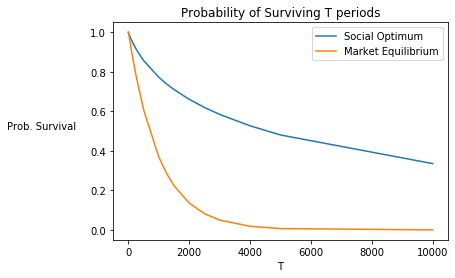

In [710]:
plt.figure(facecolor='white')

plt.plot(df_sim_so['T'], df_sim_so['psurvival'], label='Social Optimum')
plt.plot(df_sim_me['T'], df_sim_me['psurvival'], label='Market Equilibrium')

plt.xlabel('T')
h = plt.ylabel('Prob. Survival               ', labelpad=25)
h.set_rotation(0)
plt.legend()
plt.title('Probability of Surviving T periods')
plt.show()

In [838]:
def get_row(x):
    return dict(X=x, 
         **{k:v for k, v in zip(['val', 'psurvival', 'final_state', 'n_periods'], solutions[0].simulate(x) )}
    )


In [852]:
def find_new_np_x(n_periods, floor, ceil=57.72):
    while ceil > floor and (1 - floor/ceil) > 1e-4:
        x = (floor + ceil)/2
        row = get_row(x)
        if row['n_periods'] > n_periods:
            ceil = x
        else:
            floor = x
    return get_row(ceil)

In [876]:
row = find_new_np_x(1, 2.054278)
row

{'X': 7.830061778152698,
 'val': 1.3648232229370354,
 'psurvival': 0.0,
 'final_state': 0,
 'n_periods': 2}

In [871]:
df_sim2 = pd.DataFrame({
    'X': X[:127]
})
df_sim_res = df_sim2.apply(
    lambda x: list(solutions[0].simulate(x['X']))
    , axis=1
    , result_type='expand'
)
df_sim_res.columns=['val', 'psurvival', 'final_state', 'n_periods']
df_sim2 = df_sim2.merge(df_sim_res, left_index=True, right_index=True)

df_sim2.style

,X,val,psurvival,final_state,n_periods
0,2.000000,0.000000,0.000000,2.000000,0.000000
1,2.054278,0.026777,0.000000,0.000000,1.000000
2,2.110029,0.053554,0.000000,0.000000,1.000000
3,2.167292,0.080331,0.000000,0.000000,1.000000
4,2.226110,0.107109,0.000000,0.000000,1.000000
5,2.286524,0.133886,0.000000,0.000000,1.000000
6,2.348578,0.160663,0.000000,0.000000,1.000000
7,2.412316,0.187440,0.000000,0.000000,1.000000
8,2.477783,0.214217,0.000000,0.000000,1.000000
9,2.545028,0.240994,0.000000,0.000000,1.000000


In [872]:
def get_row(x):
    return dict(X=x, 
         **{k:v for k, v in zip(['val', 'psurvival', 'final_state', 'n_periods'], solutions[0].simulate(x) )}
    )


In [873]:
def find_new_np_x(n_periods, floor, ceil=57.72):
    while ceil > floor and (1 - floor/ceil) > 1e-8:
        x = (floor + ceil)/2
        row = get_row(x)
        if row['n_periods'] > n_periods:
            ceil = x
        else:
            floor = x
    return get_row(ceil)

In [874]:
floor = 2.054278
for nps in range(1,50):
    row = find_new_np_x(nps, floor)
    df_sim2 = df_sim2.append(row, ignore_index=True)
    floor = row['X']

df_sim2 = df_sim2.sort_values('X')
df_sim2.style

<ipython-input-400-4a52fb956690>:8: RuntimeWarning: overflow encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


,X,val,psurvival,final_state,n_periods
0,2.000000,0.000000,0.000000,2.000000,0.000000
1,2.054278,0.026777,0.000000,0.000000,1.000000
2,2.110029,0.053554,0.000000,0.000000,1.000000
3,2.167292,0.080331,0.000000,0.000000,1.000000
4,2.226110,0.107109,0.000000,0.000000,1.000000
5,2.286524,0.133886,0.000000,0.000000,1.000000
6,2.348578,0.160663,0.000000,0.000000,1.000000
7,2.412316,0.187440,0.000000,0.000000,1.000000
8,2.477783,0.214217,0.000000,0.000000,1.000000
9,2.545028,0.240994,0.000000,0.000000,1.000000


In [944]:
df_sim_np = df_sim2[1:].groupby('n_periods').first().reset_index()
pd.DataFrame({
    'X/N': df_sim_np['X']/N,
    'n periods': df_sim_np['n_periods']
}).style

,X/N,n periods
0,1.027139,1.000000
1,3.915031,2.000000
2,6.435125,3.000000
3,8.657755,4.000000
4,10.717294,5.000000
5,12.712358,6.000000
6,14.423106,7.000000
7,16.032657,8.000000
8,17.603689,9.000000
9,18.962283,10.000000


<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))


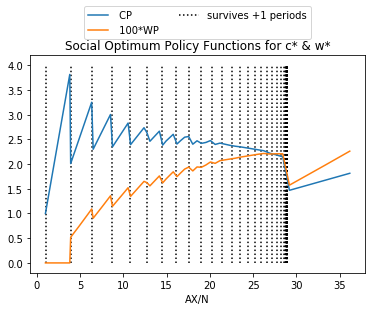

In [904]:
rng = range(0,135)

i = 0
# lab = "dev. sol "+str(i) if i > 0 else 'social opt.'
#     plt.plot(x[rng], solutions[i].XP[rng], label = " X'P")
#     plt.plot(x[rng], solutions[i].VF[rng], label = " VF")
CP = solutions[i].build_CP(XP=solutions[i].XP)
plt.plot(X[rng]/N, CP[rng],  label = (' CP') )
WP = solutions[i].build_WP(CP=CP, XP=solutions[i].XP)
plt.plot(X[rng]/N, 100*WP[rng],  label = (' 100*WP') )

# for x, n in zip(df_sim_np['X'], df_sim_np['n_periods']):
plt.vlines(df_sim_np['X']/N, 0, 4, linestyle='dotted', label='survives +1 periods')

plt.legend(loc="center", bbox_to_anchor=(0.5, 1.15), ncol=2)

# plt.plot(df_sim_np['X'][:-2], df_sim_np['n_periods'][:-2], 'o', label='nperiods')
plt.xlabel('AX/N')
# plt.legend()
plt.title("Social Optimum Policy Functions for c* & w*")
plt.show()

<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))


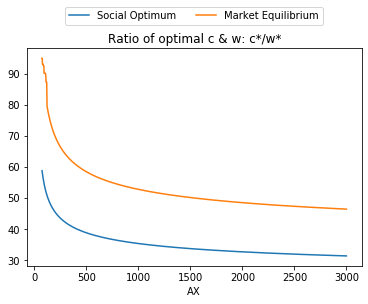

In [932]:
rng = range(160,300)

i = 0
# lab = "dev. sol "+str(i) if i > 0 else 'social opt.'
#     plt.plot(x[rng], solutions[i].XP[rng], label = " X'P")
#     plt.plot(x[rng], solutions[i].VF[rng], label = " VF")
CPso = solutions[i].build_CP(XP=solutions[i].XP)
# plt.plot(X[rng]/N, CP[rng],  label = (' CP') )
WPso = solutions[i].build_WP(CP=CPso, XP=solutions[i].XP)
plt.plot(X[rng]/N, (CPso[rng] + 1e-12)/(WPso[rng] + 1e-12),  label = ('Social Optimum') )

CPme = sol.build_CP(XP=sol.XP)
# plt.plot(X[rng]/N, CP[rng],  label = (' CP') )
WPme = sol.build_WP(CP=CPme, XP=sol.XP)
plt.plot(X[rng]/N, (CPme[rng] + 1e-12)/(WPme[rng] + 1e-12),  label = ('Market Equilibrium') )

# for x, n in zip(df_sim_np['X'], df_sim_np['n_periods']):
# plt.vlines(df_sim_np['X'], 0, 4, linestyle='dotted', label='survives +1 periods')

plt.legend(loc="center", bbox_to_anchor=(0.5, 1.15), ncol=2)

# plt.plot(df_sim_np['X'][:-2], df_sim_np['n_periods'][:-2], 'o', label='nperiods')
plt.xlabel('AX')
# plt.legend()
plt.title("Ratio of optimal c & w: c*/w*")
plt.show()

In [945]:
df_so = pd.DataFrame({
    'X/N': solutions[0].erm.xgrid/N,
    'CP': solutions[0].build_CP(),
    'WP': solutions[0].build_WP(),
    'VF': solutions[0].VF
})

df_me = pd.DataFrame({
    'X/N': sol.erm.xgrid/N,
    'CP': sol.build_CP(),
    'WP': sol.build_WP(),
    'VF': sol.build_VF()
})

df_so.merge(df_me, on='X/N', suffixes=['_SO', '_ME']).style

<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: divide by zero encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-400-4a52fb956690>:8: RuntimeWarning: invalid value encountered in true_divide
  return b0 + b1*np.log(x)/(b2 - (x**b3))


,X/N,CP_SO,WP_SO,VF_SO,CP_ME,WP_ME,VF_ME
0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,1.027139,1.027139,0.000000,0.026777,1.027139,0.000000,0.026777
2,1.055014,1.055014,0.000000,0.053554,1.055014,0.000000,0.053554
3,1.083646,1.083646,0.000000,0.080331,1.083646,0.000000,0.080331
4,1.113055,1.113055,0.000000,0.107109,1.113055,0.000000,0.107109
5,1.143262,1.143262,0.000000,0.133886,1.143262,0.000000,0.133886
6,1.174289,1.174289,0.000000,0.160663,1.174289,0.000000,0.160663
7,1.206158,1.206158,0.000000,0.187440,1.206158,0.000000,0.187440
8,1.238892,1.238892,0.000000,0.214217,1.238892,0.000000,0.214217
9,1.272514,1.272514,0.000000,0.240994,1.272514,0.000000,0.240994
